In [4]:
# Install dependencies (run this in a notebook cell, not needed in code below)
!pip install transformers datasets seqeval torch
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.6 MB/s eta 0:00:00

In [5]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline
from seqeval.metrics import classification_report, precision_score, recall_score, f1_score
import random

# Set device
device = 0 if torch.cuda.is_available() else -1
print(f"Device set to use {'cuda:0' if device == 0 else 'cpu'}")

# Load dataset
dataset = load_dataset("dell-research-harvard/newswire")
full_data = dataset["train"]

# Select 10000 random rows from the dataset
random.seed(42)  # Set seed for reproducibility
indices = random.sample(range(len(full_data)), 10000)  # Randomly sample
small_corpus = full_data.select(indices)  # Select the rows based on these indices

# Shuffle and split
random.seed(42)
indices = list(range(len(small_corpus)))
random.shuffle(indices)
split_idx = int(0.8 * len(indices))
train_data = small_corpus.select(indices[:split_idx])
test_data = small_corpus.select(indices[split_idx:])

# Optional: use smaller subset for testing speed (already done above by selecting 1000 samples)
#test_data = test_data.select(range(100))

# Define standard CoNLL-style label names
label_names = [
    "O", "B-PER", "I-PER", "B-ORG", "I-ORG",
    "B-LOC", "I-LOC", "B-MISC", "I-MISC"
]

# Define prediction function
def get_predictions(model_name, test_data):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForTokenClassification.from_pretrained(model_name)
    pipe = TokenClassificationPipeline(model=model, tokenizer=tokenizer, aggregation_strategy="simple", device=device)

    true_labels, pred_labels = [], []

    for row in test_data:
        words = row["ner_words"]
        gold = row["ner_labels"]  # Already string labels
        sentence = " ".join(words)

        prediction = pipe(sentence)

        # Initialize with "O"
        pred_seq = ["O"] * len(words)

        for ent in prediction:
            entity = ent.get("entity_group", ent.get("entity"))
            word = ent["word"]

            # Match predicted word to a token
            for idx, w in enumerate(words):
                if word.lower() in w.lower() and pred_seq[idx] == "O":
                    pred_seq[idx] = "B-" + entity
                    break

        gold_seq = gold  # Already string labels
        true_labels.append(gold_seq)
        pred_labels.append(pred_seq)

    return true_labels, pred_labels


# Define evaluation function
def evaluate_model(name, true_labels, pred_labels):
    print(f"\n=== {name} ===")
    print("Precision:", precision_score(true_labels, pred_labels))
    print("Recall:", recall_score(true_labels, pred_labels))
    print("F1 Score:", f1_score(true_labels, pred_labels))
    print("\nDetailed Report:\n", classification_report(true_labels, pred_labels))

# Evaluate Historical NER model
model_custom = "dell-research-harvard/historical_newspaper_ner"
true_custom, pred_custom = get_predictions(model_custom, test_data)
evaluate_model("Custom Historical Newspaper NER", true_custom, pred_custom)

# Evaluate RoBERTa-Large NER model
model_roberta = "Jean-Baptiste/roberta-large-ner-english"
true_roberta, pred_roberta = get_predictions(model_roberta, test_data)
evaluate_model("RoBERTa-Large (CoNLL03)", true_roberta, pred_roberta)


Device set to use cuda:0


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.98k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

1883_data_clean.json:   0%|          | 0.00/36.9M [00:00<?, ?B/s]

1880_data_clean.json:   0%|          | 0.00/26.8M [00:00<?, ?B/s]

1887_data_clean.json:   0%|          | 0.00/66.0M [00:00<?, ?B/s]

1886_data_clean.json:   0%|          | 0.00/52.4M [00:00<?, ?B/s]

1878_data_clean.json:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

1881_data_clean.json:   0%|          | 0.00/30.9M [00:00<?, ?B/s]

1879_data_clean.json:   0%|          | 0.00/20.2M [00:00<?, ?B/s]

1889_data_clean.json:   0%|          | 0.00/81.8M [00:00<?, ?B/s]

1885_data_clean.json:   0%|          | 0.00/53.1M [00:00<?, ?B/s]

1888_data_clean.json:   0%|          | 0.00/63.0M [00:00<?, ?B/s]

1893_data_clean.json:   0%|          | 0.00/103M [00:00<?, ?B/s]

1891_data_clean.json:   0%|          | 0.00/108M [00:00<?, ?B/s]

1884_data_clean.json:   0%|          | 0.00/33.8M [00:00<?, ?B/s]

1890_data_clean.json:   0%|          | 0.00/95.3M [00:00<?, ?B/s]

1882_data_clean.json:   0%|          | 0.00/29.3M [00:00<?, ?B/s]

1892_data_clean.json:   0%|          | 0.00/89.7M [00:00<?, ?B/s]

1894_data_clean.json:   0%|          | 0.00/113M [00:00<?, ?B/s]

1895_data_clean.json:   0%|          | 0.00/110M [00:00<?, ?B/s]

1896_data_clean.json:   0%|          | 0.00/126M [00:00<?, ?B/s]

1897_data_clean.json:   0%|          | 0.00/139M [00:00<?, ?B/s]

1898_data_clean.json:   0%|          | 0.00/147M [00:00<?, ?B/s]

1899_data_clean.json:   0%|          | 0.00/135M [00:00<?, ?B/s]

1900_data_clean.json:   0%|          | 0.00/123M [00:00<?, ?B/s]

1901_data_clean.json:   0%|          | 0.00/111M [00:00<?, ?B/s]

1902_data_clean.json:   0%|          | 0.00/110M [00:00<?, ?B/s]

1903_data_clean.json:   0%|          | 0.00/98.1M [00:00<?, ?B/s]

1904_data_clean.json:   0%|          | 0.00/106M [00:00<?, ?B/s]

1905_data_clean.json:   0%|          | 0.00/105M [00:00<?, ?B/s]

1906_data_clean.json:   0%|          | 0.00/116M [00:00<?, ?B/s]

1907_data_clean.json:   0%|          | 0.00/98.2M [00:00<?, ?B/s]

1908_data_clean.json:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

1909_data_clean.json:   0%|          | 0.00/114M [00:00<?, ?B/s]

1910_data_clean.json:   0%|          | 0.00/127M [00:00<?, ?B/s]

1911_data_clean.json:   0%|          | 0.00/110M [00:00<?, ?B/s]

1912_data_clean.json:   0%|          | 0.00/121M [00:00<?, ?B/s]

1913_data_clean.json:   0%|          | 0.00/125M [00:00<?, ?B/s]

1917_data_clean.json:   0%|          | 0.00/166M [00:00<?, ?B/s]

1915_data_clean.json:   0%|          | 0.00/120M [00:00<?, ?B/s]

1916_data_clean.json:   0%|          | 0.00/126M [00:00<?, ?B/s]

1914_data_clean.json:   0%|          | 0.00/121M [00:00<?, ?B/s]

1918_data_clean.json:   0%|          | 0.00/171M [00:00<?, ?B/s]

1920_data_clean.json:   0%|          | 0.00/368M [00:00<?, ?B/s]

1921_data_clean.json:   0%|          | 0.00/380M [00:00<?, ?B/s]

1919_data_clean.json:   0%|          | 0.00/171M [00:00<?, ?B/s]

1922_data_clean.json:   0%|          | 0.00/375M [00:00<?, ?B/s]

1923_data_clean.json:   0%|          | 0.00/381M [00:00<?, ?B/s]

1924_data_clean.json:   0%|          | 0.00/383M [00:00<?, ?B/s]

1925_data_clean.json:   0%|          | 0.00/383M [00:00<?, ?B/s]

1926_data_clean.json:   0%|          | 0.00/379M [00:00<?, ?B/s]

1927_data_clean.json:   0%|          | 0.00/390M [00:00<?, ?B/s]

1928_data_clean.json:   0%|          | 0.00/435M [00:00<?, ?B/s]

1929_data_clean.json:   0%|          | 0.00/460M [00:00<?, ?B/s]

1930_data_clean.json:   0%|          | 0.00/454M [00:00<?, ?B/s]

1931_data_clean.json:   0%|          | 0.00/442M [00:00<?, ?B/s]

1932_data_clean.json:   0%|          | 0.00/459M [00:00<?, ?B/s]

1933_data_clean.json:   0%|          | 0.00/459M [00:00<?, ?B/s]

1935_data_clean.json:   0%|          | 0.00/461M [00:00<?, ?B/s]

1934_data_clean.json:   0%|          | 0.00/472M [00:00<?, ?B/s]

1936_data_clean.json:   0%|          | 0.00/445M [00:00<?, ?B/s]

1937_data_clean.json:   0%|          | 0.00/450M [00:00<?, ?B/s]

1938_data_clean.json:   0%|          | 0.00/459M [00:00<?, ?B/s]

1939_data_clean.json:   0%|          | 0.00/454M [00:00<?, ?B/s]

1940_data_clean.json:   0%|          | 0.00/426M [00:00<?, ?B/s]

1941_data_clean.json:   0%|          | 0.00/435M [00:00<?, ?B/s]

1942_data_clean.json:   0%|          | 0.00/463M [00:00<?, ?B/s]

1943_data_clean.json:   0%|          | 0.00/501M [00:00<?, ?B/s]

1944_data_clean.json:   0%|          | 0.00/516M [00:00<?, ?B/s]

1945_data_clean.json:   0%|          | 0.00/499M [00:00<?, ?B/s]

1946_data_clean.json:   0%|          | 0.00/550M [00:00<?, ?B/s]

1947_data_clean.json:   0%|          | 0.00/540M [00:00<?, ?B/s]

1948_data_clean.json:   0%|          | 0.00/504M [00:00<?, ?B/s]

1949_data_clean.json:   0%|          | 0.00/507M [00:00<?, ?B/s]

1950_data_clean.json:   0%|          | 0.00/517M [00:00<?, ?B/s]

1951_data_clean.json:   0%|          | 0.00/537M [00:00<?, ?B/s]

1952_data_clean.json:   0%|          | 0.00/609M [00:00<?, ?B/s]

1953_data_clean.json:   0%|          | 0.00/630M [00:00<?, ?B/s]

1954_data_clean.json:   0%|          | 0.00/609M [00:00<?, ?B/s]

1955_data_clean.json:   0%|          | 0.00/604M [00:00<?, ?B/s]

1956_data_clean.json:   0%|          | 0.00/605M [00:00<?, ?B/s]

1957_data_clean.json:   0%|          | 0.00/622M [00:00<?, ?B/s]

1958_data_clean.json:   0%|          | 0.00/597M [00:00<?, ?B/s]

1959_data_clean.json:   0%|          | 0.00/604M [00:00<?, ?B/s]

1960_data_clean.json:   0%|          | 0.00/582M [00:00<?, ?B/s]

1961_data_clean.json:   0%|          | 0.00/561M [00:00<?, ?B/s]

1962_data_clean.json:   0%|          | 0.00/550M [00:00<?, ?B/s]

1963_data_clean.json:   0%|          | 0.00/557M [00:00<?, ?B/s]

1964_data_clean.json:   0%|          | 0.00/560M [00:00<?, ?B/s]

1965_data_clean.json:   0%|          | 0.00/510M [00:00<?, ?B/s]

1966_data_clean.json:   0%|          | 0.00/506M [00:00<?, ?B/s]

1967_data_clean.json:   0%|          | 0.00/502M [00:00<?, ?B/s]

1968_data_clean.json:   0%|          | 0.00/471M [00:00<?, ?B/s]

1969_data_clean.json:   0%|          | 0.00/482M [00:00<?, ?B/s]

1970_data_clean.json:   0%|          | 0.00/473M [00:00<?, ?B/s]

1971_data_clean.json:   0%|          | 0.00/463M [00:00<?, ?B/s]

1972_data_clean.json:   0%|          | 0.00/441M [00:00<?, ?B/s]

1973_data_clean.json:   0%|          | 0.00/419M [00:00<?, ?B/s]

1974_data_clean.json:   0%|          | 0.00/421M [00:00<?, ?B/s]

1975_data_clean.json:   0%|          | 0.00/423M [00:00<?, ?B/s]

1976_data_clean.json:   0%|          | 0.00/390M [00:00<?, ?B/s]

1977_data_clean.json:   0%|          | 0.00/364M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/23 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/999k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



=== Custom Historical Newspaper NER ===
Precision: 0.806274078150798
Recall: 0.04392276788391197
F1 Score: 0.08330727019419407

Detailed Report:
               precision    recall  f1-score   support

         LOC       0.91      0.12      0.20     11169
        MISC       0.36      0.01      0.02      7775
         ORG       0.61      0.02      0.04      4662
         PER       0.35      0.00      0.00      9748

   micro avg       0.81      0.04      0.08     33354
   macro avg       0.55      0.04      0.07     33354
weighted avg       0.57      0.04      0.08     33354



tokenizer_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/849 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Device set to use cuda:0



=== RoBERTa-Large (CoNLL03) ===
Precision: 0.150997150997151
Recall: 0.0015890148108172932
F1 Score: 0.003144933986055481

Detailed Report:
               precision    recall  f1-score   support

         LOC       0.35      0.00      0.00     11169
        MISC       0.21      0.00      0.00      7775
         ORG       0.03      0.00      0.00      4662
         PER       0.12      0.00      0.00      9748

   micro avg       0.15      0.00      0.00     33354
   macro avg       0.18      0.00      0.00     33354
weighted avg       0.21      0.00      0.00     33354



In [28]:
print(full_data)

Dataset({
    features: ['article', 'byline', 'dates', 'newspaper_metadata', 'antitrust', 'civil_rights', 'crime', 'govt_regulation', 'labor_movement', 'politics', 'protests', 'ca_topic', 'ner_words', 'ner_labels', 'wire_city', 'wire_state', 'wire_country', 'wire_coordinates', 'wire_location_notes', 'people_mentioned', 'cluster_size', 'year'],
    num_rows: 2719607
})


In [14]:
!pip install seqeval --upgrade

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import precision_score, recall_score, f1_score


def flatten_labels(true_labels, pred_labels):
    flat_true = [label for sublist in true_labels for label in sublist]
    flat_pred = [label for sublist in pred_labels for label in sublist]
    return flat_true, flat_pred

def evaluate_model(name, true_labels, pred_labels):
    print(f"\n=== {name} ===")

    # Get the flattened labels for scikit-learn metrics
    true_labels_flat, pred_labels_flat = flatten_labels(true_labels, pred_labels)

    precision = precision_score(true_labels_flat, pred_labels_flat, average='macro', zero_division=1)
    recall = recall_score(true_labels_flat, pred_labels_flat, average='macro', zero_division=1)
    f1 = f1_score(true_labels_flat, pred_labels_flat, average='macro', zero_division=1)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print("\nDetailed Report:\n", classification_report(true_labels, pred_labels, zero_division=1))

model_custom = "dell-research-harvard/historical_newspaper_ner"
true_custom, pred_custom = get_predictions(model_custom, test_data)
evaluate_model("Custom Historical Newspaper NER", true_custom, pred_custom)

model_roberta = "Jean-Baptiste/roberta-large-ner-english"
true_roberta, pred_roberta = get_predictions(model_roberta, test_data)
evaluate_model("RoBERTa-Large (CoNLL03)", true_roberta, pred_roberta)

Device set to use cuda:0



=== Custom Historical Newspaper NER ===
Precision: 0.7912509035169812
Recall: 0.1278774027868087
F1 Score: 0.13334184096610818

Detailed Report:
               precision    recall  f1-score   support

         LOC       0.91      0.12      0.20     11169
        MISC       0.36      0.01      0.02      7775
         ORG       0.61      0.02      0.04      4662
         PER       0.35      0.00      0.00      9748

   micro avg       0.81      0.04      0.08     33354
   macro avg       0.55      0.04      0.07     33354
weighted avg       0.57      0.04      0.08     33354



Device set to use cuda:0



=== RoBERTa-Large (CoNLL03) ===
Precision: 0.6224652231742801
Recall: 0.11180629816820126
F1 Score: 0.10423326687691704

Detailed Report:
               precision    recall  f1-score   support

         LOC       0.35      0.00      0.00     11169
        MISC       0.21      0.00      0.00      7775
         ORG       0.03      0.00      0.00      4662
         PER       0.12      0.00      0.00      9748

   micro avg       0.15      0.00      0.00     33354
   macro avg       0.18      0.00      0.00     33354
weighted avg       0.21      0.00      0.00     33354



In [35]:
# Convert the small_corpus to df for topic-based analysis
df = pd.DataFrame(small_corpus)

# groubpy 'ca_topic'
topic_counts = df['ca_topic'].value_counts()

<ipython-input-36-543266335873>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=topic_counts.index, x=topic_counts.values, palette='cubehelix')


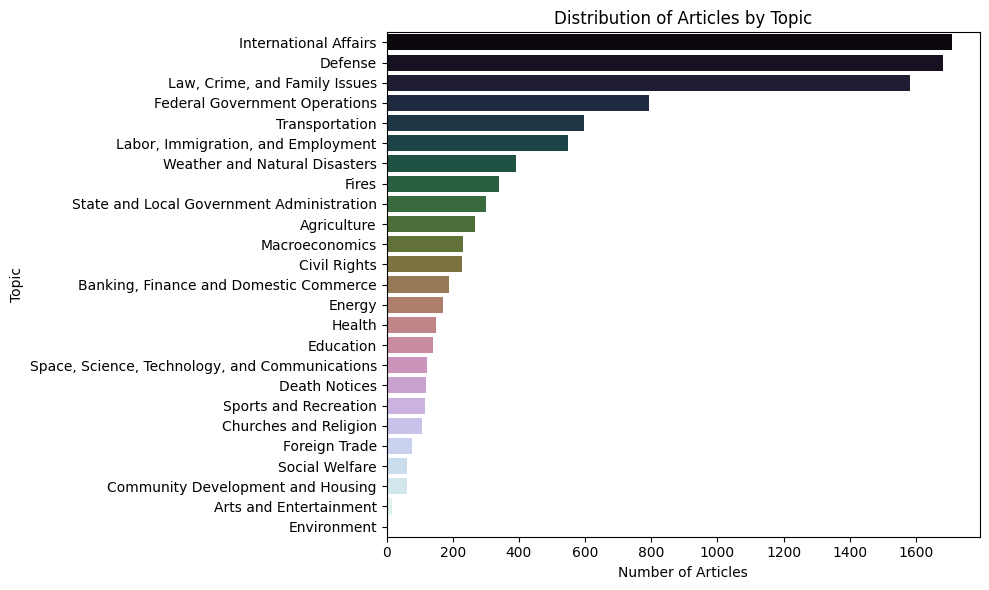

                                                B-LOC  I-LOC  B-ORG       O  \
International Affairs                           11343   3606   3176  249632   
Law, Crime, and Family Issues                    6330   2736   2100  221584   
Federal Government Operations                    4069   1474   2076  135599   
Foreign Trade                                     362     99    200   14770   
Weather and Natural Disasters                    4349   1861    463   58875   
Education                                         655    304    349   20840   
State and Local Government Administration        1259    483    842   53826   
Fires                                            1661    756    389   44694   
Defense                                         13181   4321   3620  274223   
Labor, Immigration, and Employment               1878    644   1777   88147   
Macroeconomics                                    654    181    916   51268   
Agriculture                                      115

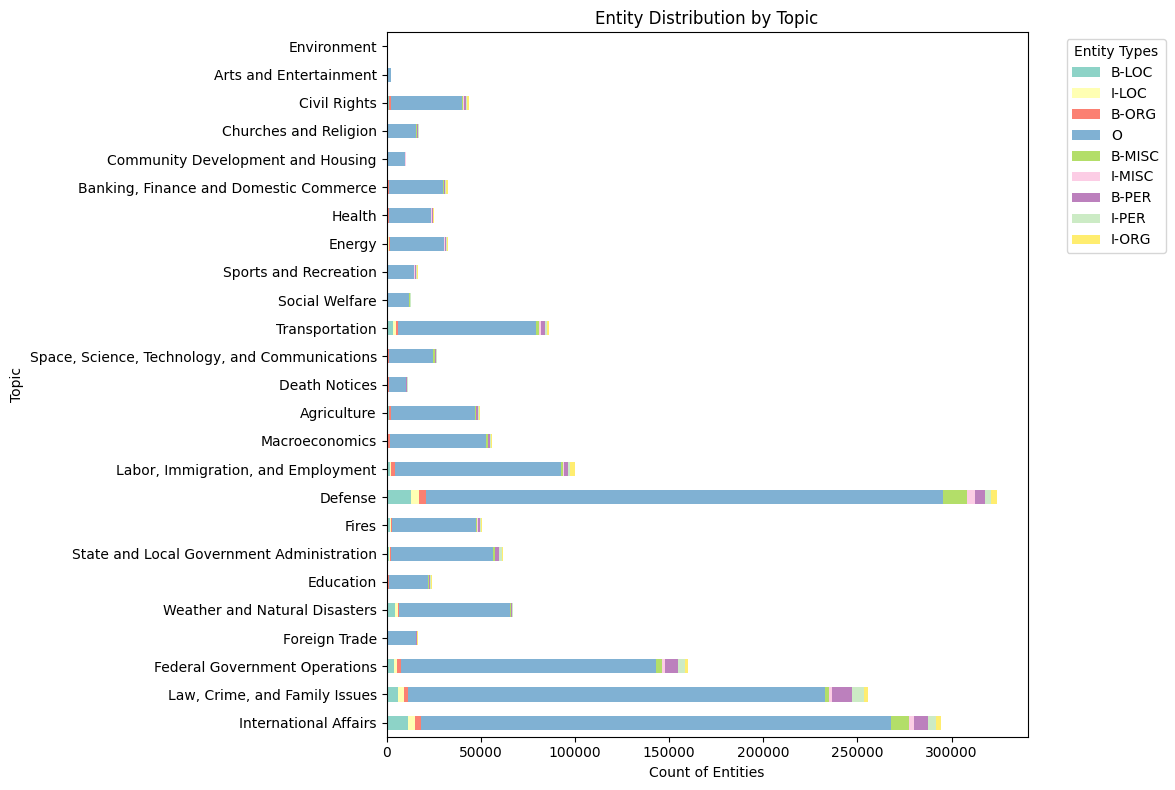

ValueError: You appear to be using a legacy multi-label data representation. Sequence of sequences are no longer supported; use a binary array or sparse matrix instead - the MultiLabelBinarizer transformer can convert to this format.

In [36]:
plt.figure(figsize=(10, 6))

sns.barplot(y=topic_counts.index, x=topic_counts.values, palette='cubehelix')
plt.title('Distribution of Articles by Topic')
plt.xlabel('Number of Articles')  
plt.ylabel('Topic')  
plt.tight_layout()
plt.show()

# Create a dictionary to store entity counts by topic
entity_counts_by_topic = {}

# Loop through each row to count the entities by topic
for i, row in df.iterrows():
    topic = row['ca_topic']
    ner_labels = row['ner_labels'] 

    # Count the entities in the row
    entity_counts = Counter(ner_labels)

    # Add the counts to the dictionary for the topic
    if topic not in entity_counts_by_topic:
        entity_counts_by_topic[topic] = Counter()
    entity_counts_by_topic[topic].update(entity_counts)

entity_counts_df = pd.DataFrame.from_dict(entity_counts_by_topic, orient='index').fillna(0)
entity_counts_df = entity_counts_df.astype(int)  # Ensure counts are integers
print(entity_counts_df)

# Plot the entity distribution by topic
entity_counts_df.plot(kind='barh', stacked=True, figsize=(12, 8), colormap='Set3')

plt.title('Entity Distribution by Topic')
plt.xlabel('Count of Entities')
plt.ylabel('Topic')
plt.legend(title='Entity Types', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Store precision, recall, and F1 score for each topic
precision_by_topic = {}
recall_by_topic = {}
f1_by_topic = {}

# Group predictions and true labels by topic
for topic in df['ca_topic'].unique():
    # Filter data by topic
    topic_data = df[df['ca_topic'] == topic]

    # Get the true labels and predicted labels
    true_labels = topic_data['ner_labels']
    #pred_labels = topic_data['ner_labels']  # Replace w predictions

    # Calculate precision, recall, and F1 score
    precision_by_topic[topic] = precision_score(true_labels, pred_labels, average='macro', zero_division=1)
    recall_by_topic[topic] = recall_score(true_labels, pred_labels, average='macro', zero_division=1)
    f1_by_topic[topic] = f1_score(true_labels, pred_labels, average='macro', zero_division=1)

metrics_df = pd.DataFrame({
    'Precision': precision_by_topic,
    'Recall': recall_by_topic,
    'F1 Score': f1_by_topic
})

metrics_df.plot(kind='barh', figsize=(12, 6), colormap='Set1')
plt.title('Model Performance by Topic')
plt.xlabel('Topic')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

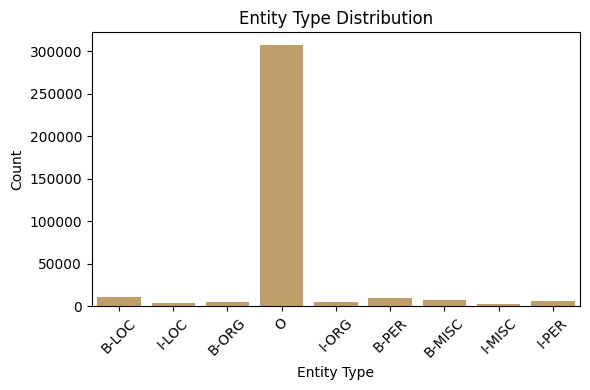

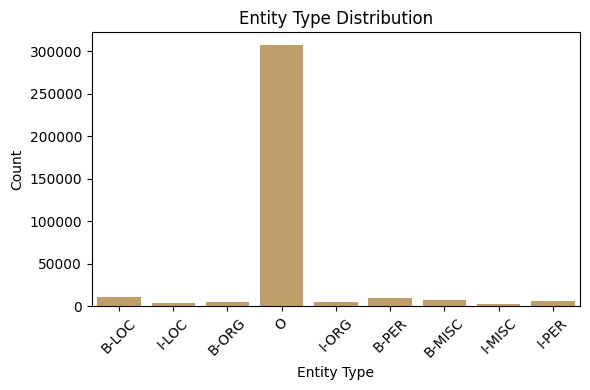

In [38]:
def plot_entity_distribution(true_labels):
    flat_labels = [label for seq in true_labels for label in seq]
    label_counts = Counter(flat_labels)

    plt.figure(figsize=(6, 4))
    sns.barplot(x=list(label_counts.keys()),
                y=list(label_counts.values()),
                color='#CFA15A')
    plt.title("Entity Type Distribution")
    plt.xlabel("Entity Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# For historical newspaper model
plot_entity_distribution(true_custom)

# For RoBERTa model
plot_entity_distribution(true_roberta)